In [75]:
import pandas as pd
import numpy as np 
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from kmeans_explainer import CFE_explainer

In [40]:
df = pd.read_csv('output/adult_violating_labeled_5.csv')
unfair_clustering_female = df[df['sex']==0]
unfair_clustering_male = df[df['sex']==1]
unfair_clustering_male

female_labels = unfair_clustering_female['unfair_label'].to_numpy()+1
male_labels = unfair_clustering_male['unfair_label'].to_numpy()+1

# Save them to a .mat file
sio.savemat('unfair_clustering_adult_5.mat', {
    'female_labels': female_labels,
    'male_labels': male_labels
})

In [41]:
unfair_clustering = df['unfair_label'].to_numpy()
fair_clustering = df['fair_label'].to_numpy()


### Cluster alignment

In [42]:
import numpy as np
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

# Jaccard similarity between two clusters
def jaccard_similarity(unfair_cluster, fair_cluster):
    intersection = len(unfair_cluster.intersection(fair_cluster))
    union = len(unfair_cluster.union(fair_cluster))
    return intersection / union if union != 0 else 0

# Build a Jaccard similarity matrix
def compute_similarity_matrix(unfair_clusters, fair_clusters):
    m, n = len(unfair_clusters), len(fair_clusters)
    similarity_matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            similarity_matrix[i, j] = jaccard_similarity(unfair_clusters[i], fair_clusters[j])
    return similarity_matrix

# Align clusters using Hungarian algorithm (minimize 1 - similarity)
def align_clusters(unfair_clusters, fair_clusters):
    similarity_matrix = compute_similarity_matrix(unfair_clusters, fair_clusters)
    cost_matrix = 1 - similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    return {i: col_ind[i] for i in range(len(row_ind))}

# Create sets of point indices for each cluster label
def get_cluster_sets(labels):
    clusters = defaultdict(set)
    for idx, label in enumerate(labels):
        clusters[label].add(idx)
    return [clusters[i] for i in sorted(clusters)]


In [43]:
labels_unfair = df["unfair_label"].tolist()
labels_fair = df["fair_label"].tolist()

cluster_A = get_cluster_sets(labels_unfair)  # Unfair clustering
cluster_B = get_cluster_sets(labels_fair)    # Fair clustering

alignment = align_clusters(cluster_A, cluster_B)
print("Cluster alignment:", alignment)


Cluster alignment: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


In [44]:
from scipy.optimize import linear_sum_assignment
import numpy as np

labels_orig = labels_unfair
labels_pert = labels_fair
k = 10

# Step 1: Build confusion matrix
conf_matrix = np.zeros((k, k), dtype=int)
for i in range(k):
    for j in range(k):
        conf_matrix[i, j] = np.sum((labels_orig == i) & (labels_pert == j))

# Step 2: Align labels using Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_map = dict(zip(col_ind, row_ind))

# Step 3: Map fair labels to aligned labels
aligned_pert = np.array([label_map[l] for l in labels_pert])

# Step 4: Compare aligned fair labels to original labels
mask = aligned_pert != labels_orig
false_count = np.sum(mask)
true_count = len(mask) - false_count
false_count


190

In [45]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import numpy as np

labels_orig = labels_unfair
labels_pert = labels_fair

k = len(np.unique(labels_orig))

conf_matrix = np.zeros((k, k), dtype=int)
for i in range(k):
    for j in range(k):
        conf_matrix[i, j] = np.sum((labels_orig == i) & (labels_pert == j))

row_ind, col_ind = linear_sum_assignment(-conf_matrix)
label_map = dict(zip(col_ind, row_ind))

aligned_fair = np.array([label_map[l] for l in labels_pert])

fair_to_unfair = dict(zip(col_ind, row_ind))
unfair_to_fair = dict(zip(row_ind, col_ind))

df['aligned_fair_label'] = df['fair_label'].map(fair_to_unfair)
df['aligned_unfair_label'] = df['unfair_label'].map(unfair_to_fair)


In [46]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(labels_orig, aligned_pert)
print("NMI between unfair and fair clustering:", nmi)


NMI between unfair and fair clustering: 0.5504613534434586


In [47]:
# Count points in each unfair cluster
unfair_counts = df["unfair_label"].value_counts().sort_index()

# Count points in each fair cluster
fair_counts = df["fair_label"].value_counts().sort_index()

print("Unfair cluster sizes:")
print(unfair_counts)

print("\nFair cluster sizes:")
print(fair_counts)


Unfair cluster sizes:
unfair_label
0    125
1    362
2    215
3      7
4    291
Name: count, dtype: int64

Fair cluster sizes:
fair_label
0     84
1    332
2    277
3      7
4    300
Name: count, dtype: int64


In [48]:
import numpy as np
from scipy.io import savemat

unfair_centers = np.load("output/adult_unfair_centers_5.npy")
savemat("output/adult_unfair_centers_5.mat", {"unfair_centers": unfair_centers})
#savemat("output/unfair_clustering_6.mat", {"labels_unfair": labels_unfair})

In [49]:
feature_cols = [col for col in df.columns if col not in ["race", "sex", "unfair_label", "fair_label"]]

fair_centers = df.groupby("fair_label")[feature_cols].mean().sort_index().values


### Find misaligned points

In [53]:
misaligned_mask = df["unfair_label"] != df["aligned_fair_label"]
# Get the misaligned points
df_misaligned = df[misaligned_mask]


In [54]:
# Count misaligned points by sex
sex_counts = df_misaligned['sex'].value_counts()

print(f"Female (0): {sex_counts.get(0, 0)}")
print(f"Male   (1): {sex_counts.get(1, 0)}")

Female (0): 130
Male   (1): 60


### Generate counterfactuals

In [55]:
from kmeans_explainer import CFE_explainer
import numpy as np

cfes_list = []

# Define mask and epsilon ratio as in your original code
mask = np.array([1, 1, 1, 1, 1,1,1,1,1,1]) 
d_eps_center_dist_ratio = 1.0

feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']

for _, row in df_misaligned.iterrows():
    factual = row[feature_cols].values.astype(float)

    # Get cluster IDs
    source_label = int(row['unfair_label'])
    target_label = int(row['aligned_fair_label'])

    # Get corresponding centers and slice to match feature_cols
    center_unfair = unfair_centers[source_label][:len(feature_cols)]
    center_fair = unfair_centers[target_label][:len(feature_cols)]

    # Generate counterfactual using explainer
    explainer = CFE_explainer(center_unfair, center_fair)
    z_optimal = explainer.compute_counterfactual(factual, mask, d_eps_center_dist_ratio)
    cfes_list.append(z_optimal)


In [56]:
import pandas as pd

feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

all_cols = cf_feature_cols
cfes_df = pd.DataFrame(cfes_list, columns=all_cols)

df_combined = df_misaligned.reset_index(drop=True).copy()
df_combined = pd.concat([df_combined, cfes_df], axis=1)


In [57]:
sex_counts = df_misaligned["sex"].value_counts().rename(index={0: "Female", 1: "Male"})
print(sex_counts)

sex
Female    130
Male       60
Name: count, dtype: int64


In [58]:
male_female_per_unfair_cluster = df_misaligned.groupby("unfair_label")["sex"].value_counts().unstack(fill_value=0)
male_female_per_unfair_cluster.columns = ["Female", "Male"]  # Assuming 0 = Female, 1 = Male
print("Per fair cluster:\n", male_female_per_unfair_cluster)


Per fair cluster:
               Female  Male
unfair_label              
0                 68     0
1                 55     5
2                  0     9
4                  7    46


### Males and Females per cluster after the fair clustering

In [59]:
male_female_per_fair_cluster = df.groupby("fair_label")["sex"].value_counts().unstack(fill_value=0)
male_female_per_fair_cluster.columns = ["Female", "Male"]


In [60]:
import numpy as np

# Feature columns used
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

# Compute Euclidean distances
distances = np.sqrt(((df_combined[feature_cols].values - df_combined[cf_feature_cols].values) ** 2).sum(axis=1))

# Add to the DataFrame
df_combined["euclidean_distance"] = distances

In [61]:
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income'
               ]
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

change_flags = (df_combined[feature_cols].values != df_combined[cf_feature_cols].values)
change_counts = change_flags.sum(axis=0)
feature_change_frequency = pd.Series(change_counts, index=feature_cols)
feature_change_frequency = feature_change_frequency.sort_values(ascending=False)
print("Feature Change Frequency:\n", feature_change_frequency)


Feature Change Frequency:
 age               190
final-weight      190
education-num     190
marital-status    190
occupation        190
relationship      190
capital-gain      190
hours-per-week    190
native-country    190
income            190
dtype: int32


In [62]:
change_magnitude = np.abs(df_combined[cf_feature_cols].values - df_combined[feature_cols].values)
average_change = change_magnitude.mean(axis=0)

feature_change_magnitude = pd.Series(average_change, index=feature_cols)
feature_change_magnitude = feature_change_magnitude.sort_values(ascending=False)
print("Feature Change Magnitude (Average):\n", feature_change_magnitude)


Feature Change Magnitude (Average):
 relationship      1.355191
income            0.807629
marital-status    0.734159
age               0.548653
hours-per-week    0.419190
education-num     0.358969
occupation        0.127618
capital-gain      0.090663
native-country    0.078051
final-weight      0.047303
dtype: float64


In [63]:
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income'
               ]
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
changed = df_combined[cf_feature_cols].values != df_combined[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_combined[cf_feature_cols].values - df_combined[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]
feature_summary
df_combined.to_csv('df_balance.csv', index=False)

C:\Users\tania\AppData\Local\Temp\ipykernel_1980\3591645609.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped, x='Sex Label', y='euclidean_distance', palette='Set2')


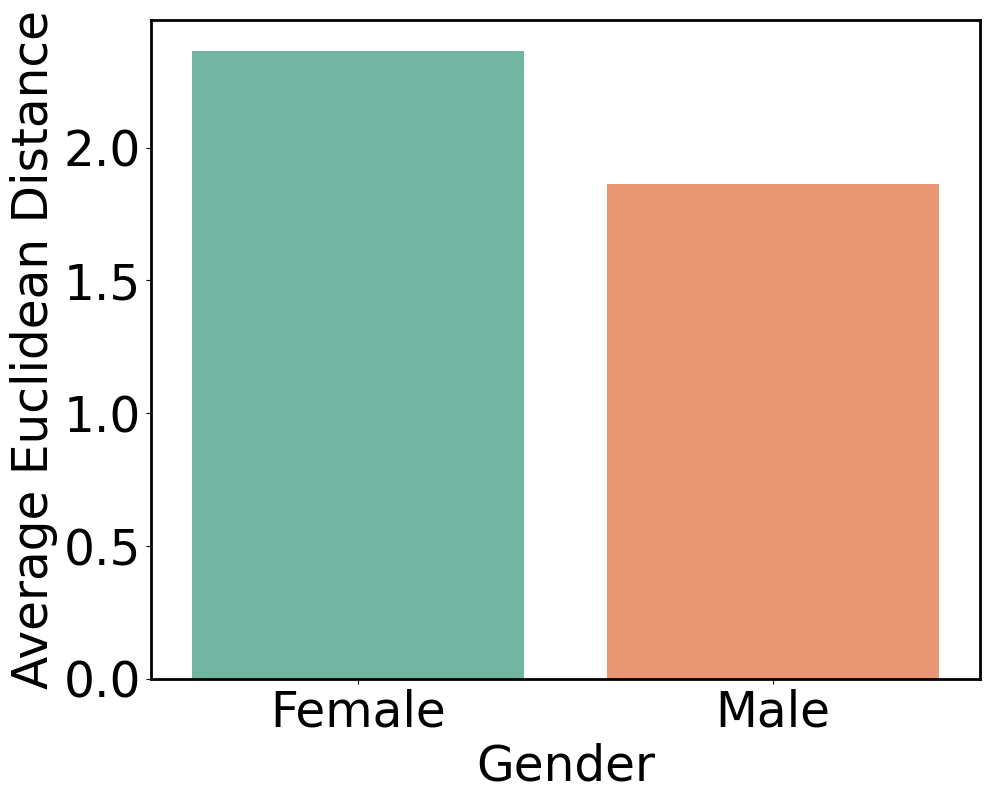

In [64]:
df_combined['Sex Label'] = df_combined['sex'].map({1: 'Male', 0: 'Female'})
df_grouped = df_combined.groupby('Sex Label')['euclidean_distance'].mean().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(data=df_grouped, x='Sex Label', y='euclidean_distance', palette='Set2')
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)    
plt.xlabel("Gender",fontsize=35)
plt.ylabel("Average Euclidean Distance",fontsize=35)
plt.grid(axis='y', linestyle='', alpha=0.1)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.tight_layout()
plt.savefig("avg_cf_dist_by_group.pdf", format="pdf", bbox_inches="tight")

plt.show()


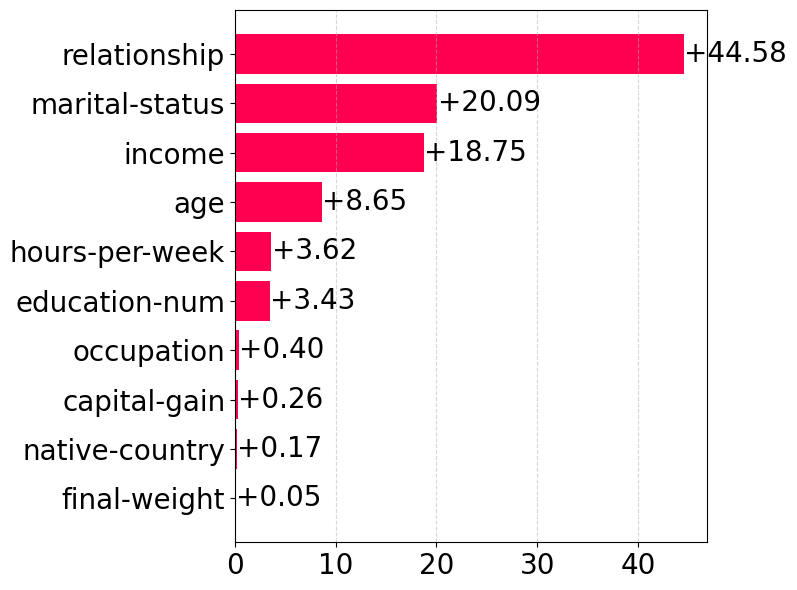

In [65]:
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

# Plot
plt.figure(figsize=(8, 6))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


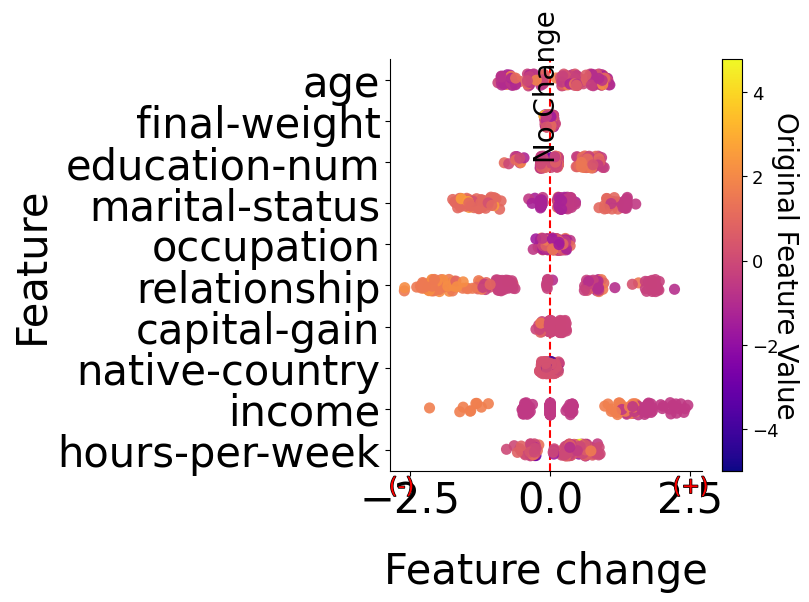

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

feature_labels = {
    'age': 'Age (normalized)',
    'final-weight': 'Final Weight (normalized)',
    'education-num': 'Education (num)',
    'marital-status': 'Marital-status',
    'occupation':'occupation',
    'relationship':'relationship',
    'capital-gain': 'Capital Gain',
    'native-country':'native-country',
    'income':'income',
    'hours-per-week': 'Hours per Week'
}
features = list(feature_labels.keys())
records = []
for feature in features:
    factual_values = df_combined[feature].values
    cf_values = df_combined[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

df = pd.DataFrame(records)
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

# Plot
plt.figure(figsize=(8,6))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=features
)

# Colorbar setup
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

# Labels
ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

# Annotate changes
decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

# Vertical zero line and annotation
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [67]:
df_female = df_combined[df_combined['sex'] == 0]
df_male = df_combined[df_combined['sex'] == 1]


### Explanations of the female

In [68]:
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income']
cf_feature_cols = [f"cf_{col}" for col in feature_cols]
changed = df_female[cf_feature_cols].values != df_female[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_female[cf_feature_cols].values - df_female[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


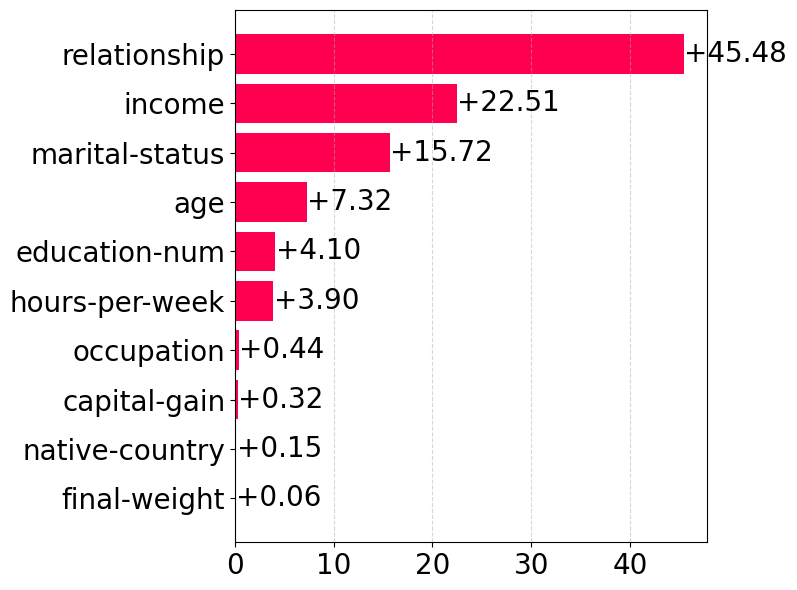

In [69]:
feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot_balance_female.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


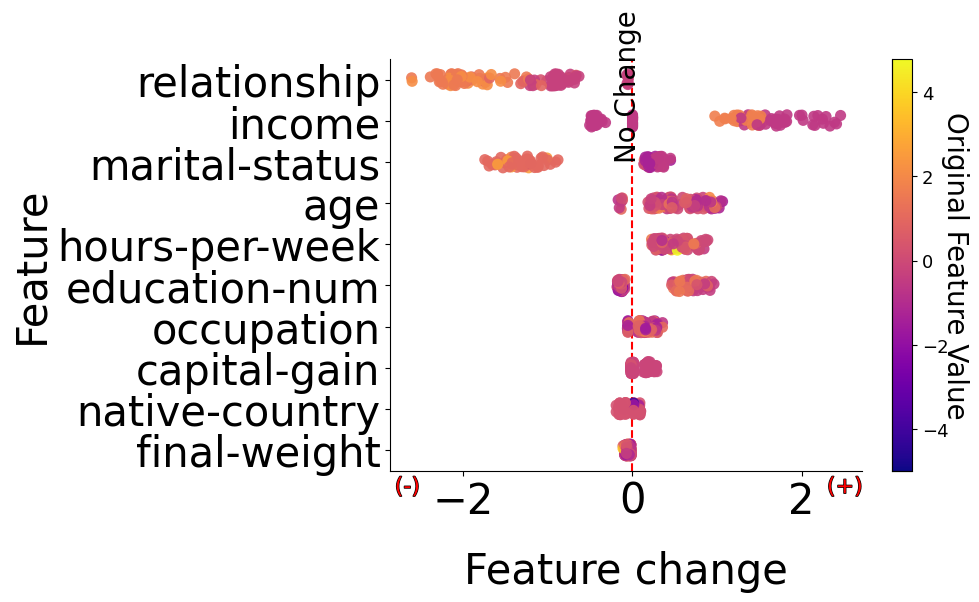

In [70]:

import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

feature_labels = {
    'age': 'Age (normalized)',
    'final-weight': 'Final Weight (normalized)',
    'education-num': 'Education (num)',
    'marital-status': 'Marital-status',
    'occupation':'occupation',
    'relationship':'relationship',
    'capital-gain': 'Capital Gain',
    'native-country':'native-country',
    'income':'income',
    'hours-per-week': 'Hours per Week'
}
features = list(feature_labels.keys())
records = []
for feature in features:
    factual_values = df_female[feature].values
    cf_values = df_female[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

# Convert to DataFrame
df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

plt.figure(figsize=(10, 6))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  
)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_female.pdf", format="pdf", bbox_inches="tight")

plt.show()


### MALE EXPLANATION

In [71]:
feature_cols = ['age', 'final-weight', 'education-num','marital-status','occupation','relationship', 'capital-gain', 'hours-per-week','native-country','income'
]
cf_feature_cols = [f"cf_{col}" for col in feature_cols]

changed = df_male[cf_feature_cols].values != df_male[feature_cols].values
change_counts = changed.sum(axis=0)

squared_diffs = (df_male[cf_feature_cols].values - df_male[feature_cols].values) ** 2
total_dists_squared = squared_diffs.sum(axis=1, keepdims=True)
contributions = np.divide(squared_diffs, total_dists_squared, where=total_dists_squared != 0)

avg_contributions = contributions.mean(axis=0)

feature_summary = pd.DataFrame({
    "Feature": feature_cols,
    "Avg Contribution to Distance": avg_contributions
}).sort_values(by="Avg Contribution to Distance", ascending=False)

feature_summary.reset_index(drop=True, inplace=True)
feature_summary
feature_summary["Avg Contribution (%)"] = feature_summary["Avg Contribution to Distance"] * 100
feature_summary = feature_summary[["Feature", "Avg Contribution (%)"]]


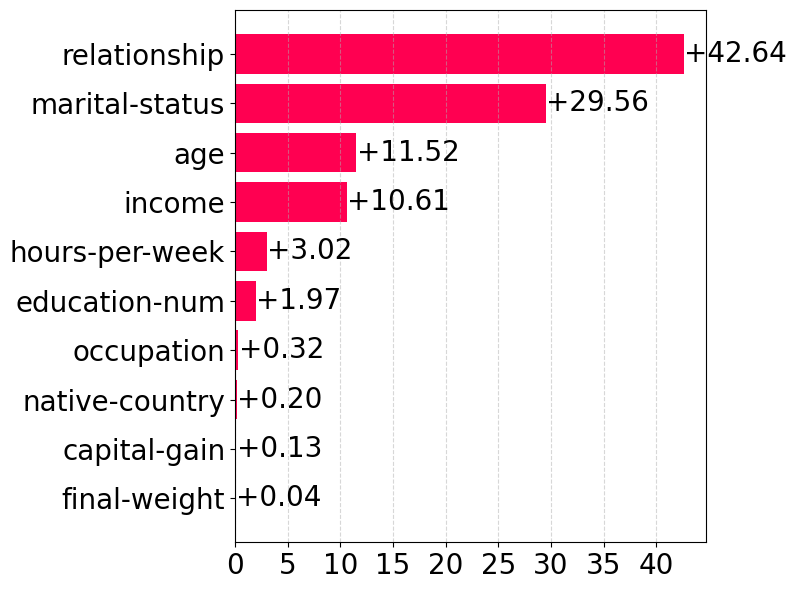

In [72]:
import matplotlib.pyplot as plt

feature_summary = feature_summary.sort_values(by="Avg Contribution (%)", ascending=True)

plt.figure(figsize=(8, 6))
bars = plt.barh(feature_summary["Feature"], feature_summary["Avg Contribution (%)"], color="#FF0051")

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height()/2,
             f"+{width:.2f}", va='center', fontsize=20)
    
    
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)    

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.savefig("feature_contribution_plot_balance_male.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout()
plt.show()


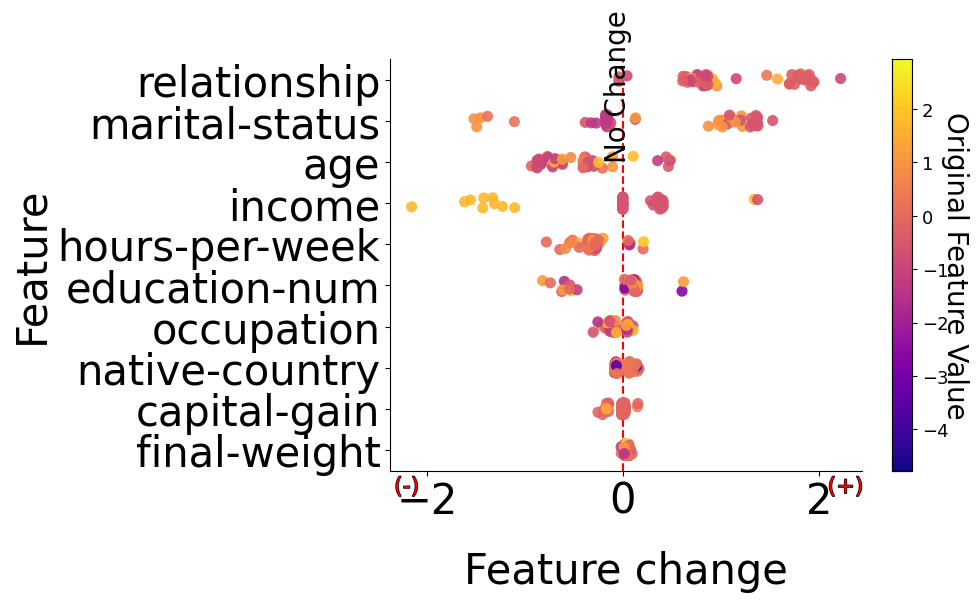

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects

feature_labels = {
    'age': 'Age (normalized)',
    'final-weight': 'Final Weight (normalized)',
    'education-num': 'Education (num)',
    'marital-status': 'Marital-status',
    'occupation':'occupation',
    'relationship':'relationship',
    'capital-gain': 'Capital Gain',
    'native-country':'native-country',
    'income':'income',
    'hours-per-week': 'Hours per Week'
}
features = list(feature_labels.keys())

records = []
for feature in features:
    factual_values = df_male[feature].values
    cf_values = df_male[f'cf_{feature}'].values
    deltas = cf_values - factual_values

    for f_val, delta in zip(factual_values, deltas):
        records.append({
            'Feature': feature,
            'Delta': delta,
            'FactualValue': f_val
        })

# Convert to DataFrame
df = pd.DataFrame(records)

feature_order = (
    df.groupby("Feature")["Delta"]
    .apply(lambda x: np.mean(np.abs(x)))
    .sort_values(ascending=False)
    .index
    .tolist()
)

# Normalize color scale based on factual values
cmap = plt.cm.plasma
norm = mcolors.Normalize(vmin=df['FactualValue'].min(), vmax=df['FactualValue'].max())

# Plot
plt.figure(figsize=(10, 6))
ax = sns.stripplot(
    data=df,
    x='Delta', y='Feature',
    hue='FactualValue',
    palette=cmap,
    dodge=False, jitter=0.15, size=8, alpha=0.9,
    order=feature_order  # dynamic order
)
# Colorbar setup
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Original Feature Value", rotation=270, labelpad=15, fontsize=20)
cbar.ax.tick_params(labelsize=13)

# Labels
ax.set_xlabel("Feature change", fontsize=30, labelpad=20)
ax.set_ylabel("Feature", fontsize=30)
ax.tick_params(axis='x', labelsize=30)
ax.tick_params(axis='y', labelsize=30)
ax.legend_.remove()

# Annotate changes
decrease_text = ax.text(df['Delta'].min() - 0.05, ax.get_ylim()[0] + 0.65, '(-)',
                        ha='center', va='bottom', fontsize=16, color='red')
increase_text = ax.text(df['Delta'].max() + 0.05, ax.get_ylim()[0] + 0.65, '(+)',
                        ha='center', va='bottom', fontsize=16, color='red')

for txt in [decrease_text, increase_text]:
    txt.set_path_effects([path_effects.Stroke(linewidth=1.0, foreground='black'),
                          path_effects.Normal()])

# Vertical zero line and annotation
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.text(-0.05, ax.get_ylim()[1] + 2.5, 'No Change',
        ha='center', va='bottom', fontsize=20, color='black', rotation=90)

sns.despine()
plt.tight_layout()
plt.savefig("explainability_balance_male.pdf", format="pdf", bbox_inches="tight")

plt.show()
